# Example notebook: Loading a simulation from the Fisher dataset

Authors: Adélie Gorce, Ian Hothi, & Sambit Giri

In this notebook, we give an example of how to load one of the simulation from the dataset, plot it, and compute its power spectrum.


The data has been simulated using 21cmFast. The XY plane has an extent of 200Mpc/h or ~295Mpc for $h=0.6774$, with 256 pixels on each side. The line-of-sight (redshift) has been simulated to be between z = 8.82 (144.60 MHz) and z = 9.33 (137.46 MHz), comprising 128 frequency channels. The three parameters chosen to be changed are the virial temperature, maximum bubble size, and the ionising efficiency parameter—these were all found to have the strongest impact on the signal. 

These are the parameter variations (fiducial value $\pm$ change):

- $T_{Vir}$: $50000\pm 5000$
- $R_{Max}$: $15\pm 5 Mpc$
- $\zeta$: $30\pm 5$,
400 simulations were run for each parameter value, which will be used for the derivatives. In the loaded files, there will be two files for each parameter, one corresponding to the plus value - for example, for $T_{Vir}$ tue value would be 50000 + 5000. Whereas the minus value would be 50000 - 5000.


400 simulations were run with the fiducial values, this will serve to calculate the covariances of the statistics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
# For power spectrum calculations
import tools21cm as t2c

In [3]:
seed = 123456 # Choose your favorite number
np.random.seed(seed)

In [4]:
h = 0.6774

## Load metadata and simulation

In [ ]:
# Folder containing the simulations
# ddir = '/data/cluster/agorce/SKA_chapter_simulations/'
ddir = './SKA_chapter_simulations/' # This folder can be created inside the repository folder. It will be ignored during the git commit.
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [8]:
# Read h5py file to obtain metadata
with h5py.File(file, 'r') as f:
    frequencies = f['frequencies'][...]  # frequencies along the lightcone
    redshifts = f['redshifts'][...]  # redshifts along the lightcone
    box_length = float(f['box_length'][0])/h  # Mpc
    ngrid = int(f['ngrid'][0])  # number of pixels along the sky patch
    nrand = int(f['nrealisations'][0])  # number of realisations for a given parameter set
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}, mean redshift {np.mean(redshifts):.2f}.')

Lightcone runs from z=8.82 to z = 9.33, mean redshift 9.07.


In [11]:
# The physical length along the line-of-sight (LoS) is different from the field-of-view (FoV).
# Below the list box_length_list should be provided to power spectrum calculator of tools21cm to take this into account.
cdists = cos.comoving_distance(redshifts)
box_length_los = (cdists.max()-cdists.min()).value
box_length_list = [box_length, box_length, box_length_los]

print(f'Box length = {box_length:.1f} (FoV) and {box_length_los:.1f} (LoS) Mpc.')

Box length = 295.2 (FoV) and 126.5 (LoS) Mpc.


In [12]:
# Pick a redshift for plots
iz = np.random.randint(nfreq)

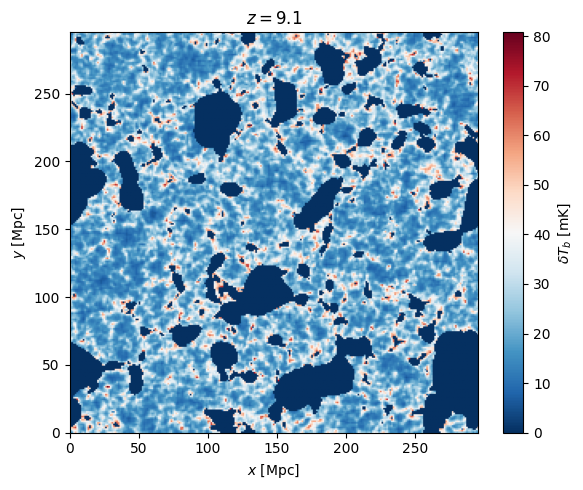

In [13]:
# Read h5py file for iz-th redshift and i-th realisation
i = np.random.randint(nrand)

with h5py.File(file, 'r') as f:
    coeval_slice = f['brightness_lightcone'][i, iz, :, :]  # Reads only (nz, n, n), not entire data

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    coeval_slice,
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'$z={redshifts[iz]:.1f}$')
fig.tight_layout()

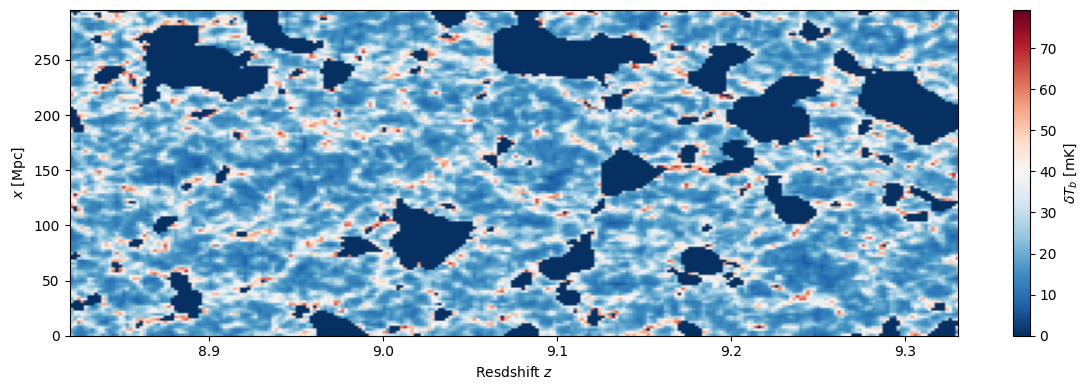

In [14]:
# Read h5py file for slice of lightcone iz-th redshift and i-th realisation
ix = np.random.randint(ngrid)

with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i, :, ix, :]  # Reads only (nz, n, n), not entire data

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
im = ax.imshow(
    lc,
    extent=(redshifts.min(), redshifts.max(), 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'Resdshift $z$')
ax.set_ylabel(r'$x$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
fig.tight_layout()

Text(0, 0.5, '$\\langle \\delta T_b(z) \\rangle$ [mK]')

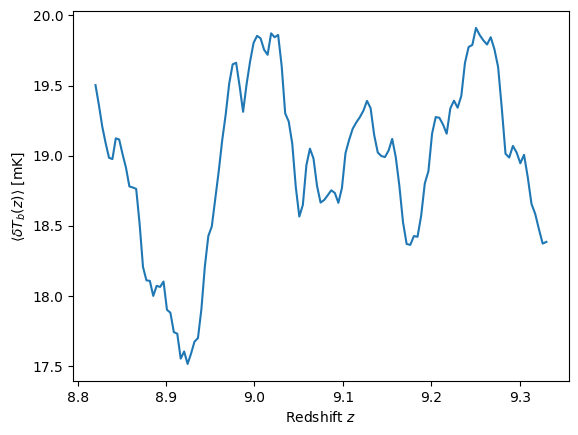

In [15]:
with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i]  # Reads only (nz, n, n), not entire data

plt.figure()
plt.plot(redshifts, np.mean(lc, axis=(1, 2)))
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\langle \delta T_b(z) \rangle$ [mK]')

## Power spectrum

In [16]:
# load full lightcone
with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i, ...]
# move los axis to match t2c
lc = np.moveaxis(lc, 0, 2)

In [17]:
# Power spectra
nbins = 15
k_nyquist = np.pi/box_length*ngrid
# Fiducial 
ps_sim, ks = t2c.power_spectrum_1d(lc, kbins=15, box_dims=box_length_list)

Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

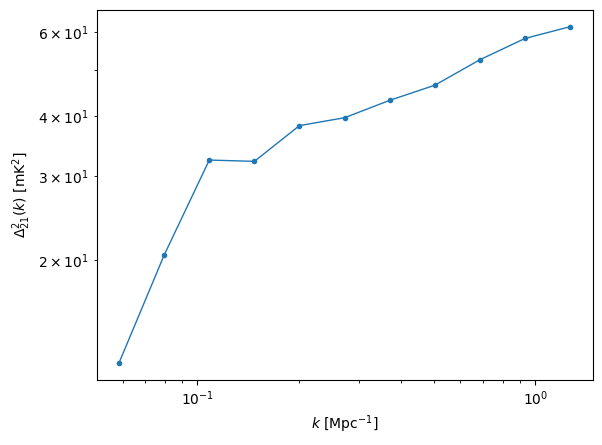

In [18]:
fig, ax = plt.subplots()
ax.loglog(ks[ks<k_nyquist/2], ps_sim[ks<k_nyquist/2]*ks[ks<k_nyquist/2]**3/2/np.pi**2, lw=1., marker='.')
ax.set_ylabel(r'$\Delta^2_{21}(k)$ [mK$^2$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
# plt.ylim(1e3, 1e8)